# Pytorch VAEs


https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [2]:

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define training function
def train(model, optimizer, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1.,))
])
train_loader = DataLoader(datasets.MNIST('../../data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)

# Instantiate VAE model
input_dim = 784
hidden_dim = 400
latent_dim = 20
model = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train model
train(model, optimizer, train_loader, epochs=1)


Train Epoch: 0 [0/60000 (0%)]	Loss: 550.207458
Train Epoch: 0 [12800/60000 (21%)]	Loss: 190.350342
Train Epoch: 0 [25600/60000 (43%)]	Loss: 151.234268
Train Epoch: 0 [38400/60000 (64%)]	Loss: 137.632248
Train Epoch: 0 [51200/60000 (85%)]	Loss: 140.802460


### Computing Graph

In [3]:
device

device(type='mps')

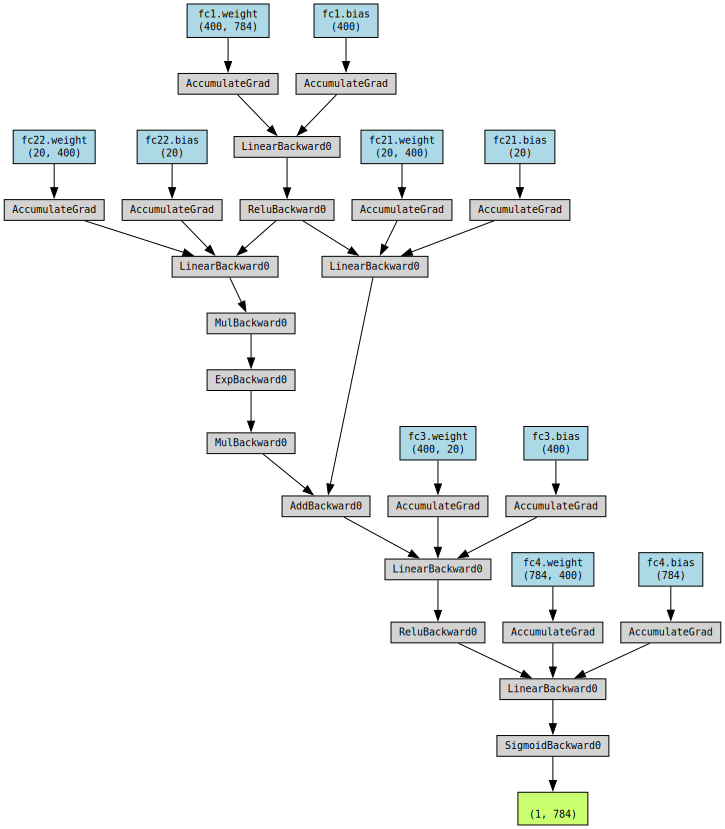

In [5]:
import torchviz 
import torch.nn.functional as F 

sample_input = torch.randn(1, 784).to(device)
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
recon_batch, mu, logvar = model(sample_input)

torchviz.make_dot(recon_batch, params=dict(model.named_parameters()))

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [7]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Create Models

In [9]:
# Get cpu or gpu device for training.
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing the Model Parameters

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.291654  [    0/60000]
loss: 2.282848  [ 6400/60000]
loss: 2.266865  [12800/60000]
loss: 2.265265  [19200/60000]
loss: 2.247287  [25600/60000]
loss: 2.202792  [32000/60000]
loss: 2.217467  [38400/60000]
loss: 2.172086  [44800/60000]
loss: 2.157700  [51200/60000]
loss: 2.136485  [57600/60000]
Test Error: 
 Accuracy: 52.5%, Avg loss: 2.127187 

Epoch 2
-------------------------------
loss: 2.134074  [    0/60000]
loss: 2.123021  [ 6400/60000]
loss: 2.061254  [12800/60000]
loss: 2.081774  [19200/60000]
loss: 2.023906  [25600/60000]
loss: 1.953837  [32000/60000]
loss: 1.985931  [38400/60000]
loss: 1.893523  [44800/60000]
loss: 1.887475  [51200/60000]
loss: 1.823073  [57600/60000]
Test Error: 
 Accuracy: 55.0%, Avg loss: 1.818585 

Epoch 3
-------------------------------
loss: 1.854508  [    0/60000]
loss: 1.823535  [ 6400/60000]
loss: 1.698662  [12800/60000]
loss: 1.749592  [19200/60000]
loss: 1.632049  [25600/60000]
loss: 1.585766  [32000/600

### Model Save & Load

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [14]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

/var/folders/m8/ggfmwhcj14n19q15bvb83t7w0000gq/T/ipykernel_87745/2530950219.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth")

<All keys matched successfully>

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    print(f'pred: "{pred}"')
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

pred: "tensor([[-1.0258, -1.1461, -0.4273, -1.1438, -0.4428,  0.7741, -0.5096,  1.1246,
          0.8080,  1.6089]])"
Predicted: "Ankle boot", Actual: "Ankle boot"
